In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import silhouette_score
import seaborn as sns
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

In [40]:
# Specify the path to the BindingDB dataset file
file_path = 'BindingDB_All.tsv'

# Step 1: Selective loading of columns to reduce memory usage
# Specify the columns to load
list_columns_kept = ['Ligand SMILES', 'Target Name', 'Target Source Organism According to Curator or DataSource', 'Target Name', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)', 'pH', 'Temp (C)', 
                'Number of Protein Chains in Target (>1 implies a multichain complex)', 'BindingDB Target Chain Sequence', 'BindingDB Target Chain Sequence.1',
                'BindingDB Target Chain Sequence.2', 'BindingDB Target Chain Sequence.3', 'BindingDB Target Chain Sequence.4', 'BindingDB Target Chain Sequence.5',
                'BindingDB Target Chain Sequence.6', 'BindingDB Target Chain Sequence.7', 'BindingDB Target Chain Sequence.8', 'BindingDB Target Chain Sequence.9', 
                'BindingDB Target Chain Sequence.10', 'BindingDB Target Chain Sequence.11', 'BindingDB Target Chain Sequence.12']
data = pd.read_csv(file_path, sep='\t', usecols=list_columns_kept, na_values=['', 'NULL'])
df = pd.DataFrame(data)
df.head()

C:\Users\hudrya\AppData\Local\Temp\ipykernel_15760\2486889280.py:11: DtypeWarning: Columns (8,9,10,11,12,13,15,50,62,74,86,98,110,122,134,146,158,170,182) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, sep='\t', usecols=list_columns_kept, na_values=['', 'NULL'])


,Ligand SMILES,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),kon (M-1-s-1),koff (s-1),pH,...,BindingDB Target Chain Sequence.3,BindingDB Target Chain Sequence.4,BindingDB Target Chain Sequence.5,BindingDB Target Chain Sequence.6,BindingDB Target Chain Sequence.7,BindingDB Target Chain Sequence.8,BindingDB Target Chain Sequence.9,BindingDB Target Chain Sequence.10,BindingDB Target Chain Sequence.11,BindingDB Target Chain Sequence.12
0,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.24,NaN,NaN,NaN,NaN,NaN,5.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.25,NaN,NaN,NaN,NaN,NaN,5.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.41,NaN,NaN,NaN,NaN,NaN,5.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.8,NaN,NaN,NaN,NaN,NaN,5.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.99,NaN,NaN,NaN,NaN,NaN,5.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
#metric analysis to find which one between Ki and Kd are mostly present values in the dataset
non_nan_ki = data['Ki (nM)'].count()
print('Numbers of data containing Ki information: ', non_nan_ki)

non_nan_kd = data['Kd (nM)'].count()
print('Numbers of data containing Kd information: ', non_nan_kd)

Numbers of data containing Ki information:  591908
Numbers of data containing Kd information:  110827


We have information about Ki more than Kd in the dataset.

In [42]:
# Drop rows that contain any NaN value
df_cleaned = data.dropna(subset= ['Ligand SMILES', 'Target Name', 'Target Source Organism According to Curator or DataSource', 'Ki (nM)'], how = 'any')
df_cleaned.reset_index
#df_cleaned.head()


<bound method DataFrame.reset_index of                                              Ligand SMILES  \
0        O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...   
1        O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...   
2        O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...   
3        OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...   
4        OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...   
...                                                    ...   
2913146                            NOCc1ccc(cc1)S(N)(=O)=O   
2913147                         CC(=O)Nc1nnc(s1)S(N)(=O)=O   
2913148  CC(C)C[C@H](NC(=O)[C@H](CO)NC(=O)\C=N\OCc1ccc(...   
2913149  CC(C)C[C@H](NC(=O)[C@H](CO)NC(=O)\C=N\OCc1ccc(...   
2913150   NC(=O)[C@H](CO)NC(=O)\C=N\OCc1ccc(cc1)S(N)(=O)=O   

                                    Target Name  \
0        Dimer of Gag-Pol polyprotein [501-599]   
1        Dimer of Gag-Pol polyprotein [501-599]   
2        Dimer of Gag-Pol polyprotein [501-599]   
3        Dim

In [43]:
#HIV1 targeting coumpunds
hiv_data = df_cleaned[df_cleaned['Target Source Organism According to Curator or DataSource'].str.contains("Human immunodeficiency virus 1", case=False, na=False)].copy()
print(hiv_data.size)

108750


Number of targets of the comounds in HIV1:  126


C:\Users\hudrya\AppData\Local\Temp\ipykernel_15760\4202495263.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Compound Count', y='Target Name', data=target_counts.head(20), palette='viridis')


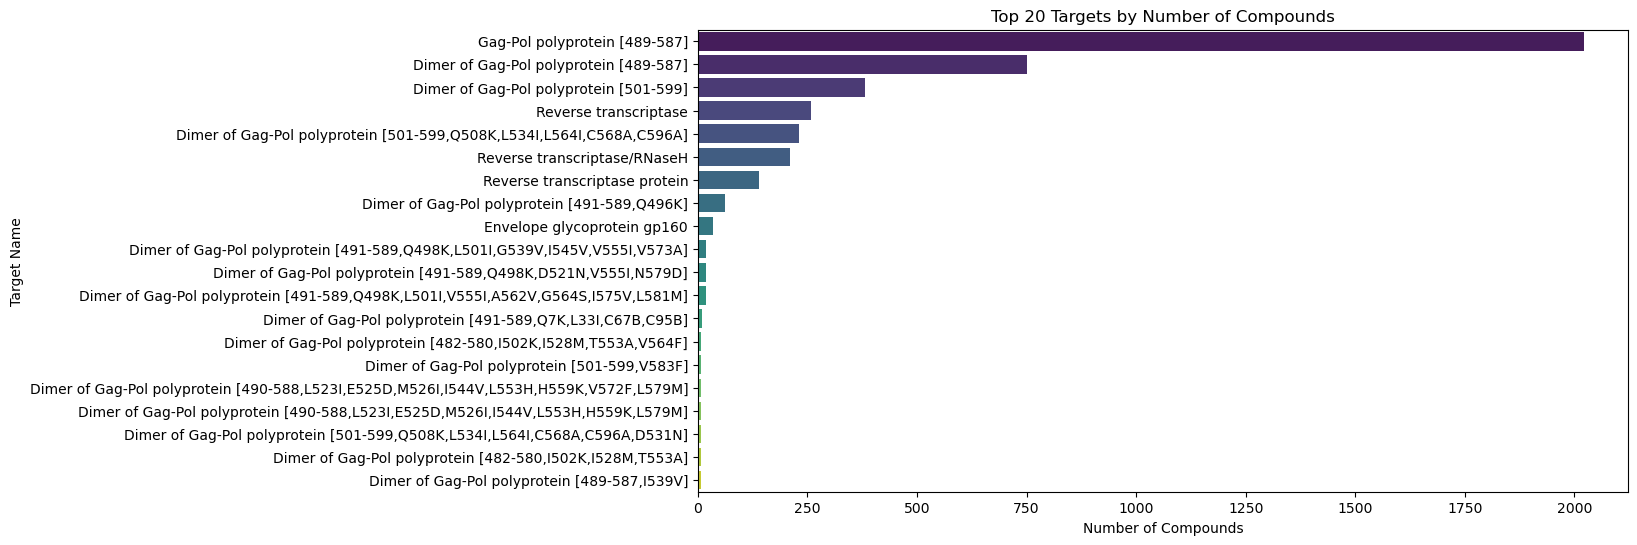

In [44]:
target_counts = hiv_data.groupby('Target Name').size().reset_index(name='Compound Count')

# Step 5: Sort targets by the number of compounds
target_counts = target_counts.sort_values(by='Compound Count', ascending=False)
print('Number of targets of the comounds in HIV1: ', target_counts.size)

# Step 6: Plot the distribution of targets
plt.figure(figsize=(12, 6))
sns.barplot(x='Compound Count', y='Target Name', data=target_counts.head(20), palette='viridis')
plt.title('Top 20 Targets by Number of Compounds')
plt.xlabel('Number of Compounds')
plt.ylabel('Target Name')
plt.show()

In [45]:
# Step 1: Generate Morgan Fingerprints
def generate_fingerprints(smiles_list, radius=2, n_bits=1024):
    """Generates Morgan fingerprints for a list of SMILES strings using MorganGenerator."""
    generator = GetMorganGenerator(radius=radius, fpSize=n_bits)  
    fingerprints = []
    
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp = generator.GetFingerprint(mol)
            arr = np.zeros((1,), dtype=int)
            AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
            fingerprints.append(arr)
        else:
            fingerprints.append(None)
    
    return np.array([fp for fp in fingerprints if fp is not None])  # Remove None entries

doing radius 2


C:\Users\hudrya\AppData\Local\Temp\ipykernel_15760\419200475.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, inertia, 'bo-', markersize=8, label=f'radius = {radius}',color=pallete[radius])


doing radius 6


C:\Users\hudrya\AppData\Local\Temp\ipykernel_15760\419200475.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, inertia, 'bo-', markersize=8, label=f'radius = {radius}',color=pallete[radius])


doing radius 10


C:\Users\hudrya\AppData\Local\Temp\ipykernel_15760\419200475.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, inertia, 'bo-', markersize=8, label=f'radius = {radius}',color=pallete[radius])


doing radius 14


C:\Users\hudrya\AppData\Local\Temp\ipykernel_15760\419200475.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, inertia, 'bo-', markersize=8, label=f'radius = {radius}',color=pallete[radius])


doing radius 18


C:\Users\hudrya\AppData\Local\Temp\ipykernel_15760\419200475.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, inertia, 'bo-', markersize=8, label=f'radius = {radius}',color=pallete[radius])


doing radius 22


C:\Users\hudrya\AppData\Local\Temp\ipykernel_15760\419200475.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, inertia, 'bo-', markersize=8, label=f'radius = {radius}',color=pallete[radius])


doing radius 26


C:\Users\hudrya\AppData\Local\Temp\ipykernel_15760\419200475.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, inertia, 'bo-', markersize=8, label=f'radius = {radius}',color=pallete[radius])


doing radius 30


C:\Users\hudrya\AppData\Local\Temp\ipykernel_15760\419200475.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, inertia, 'bo-', markersize=8, label=f'radius = {radius}',color=pallete[radius])


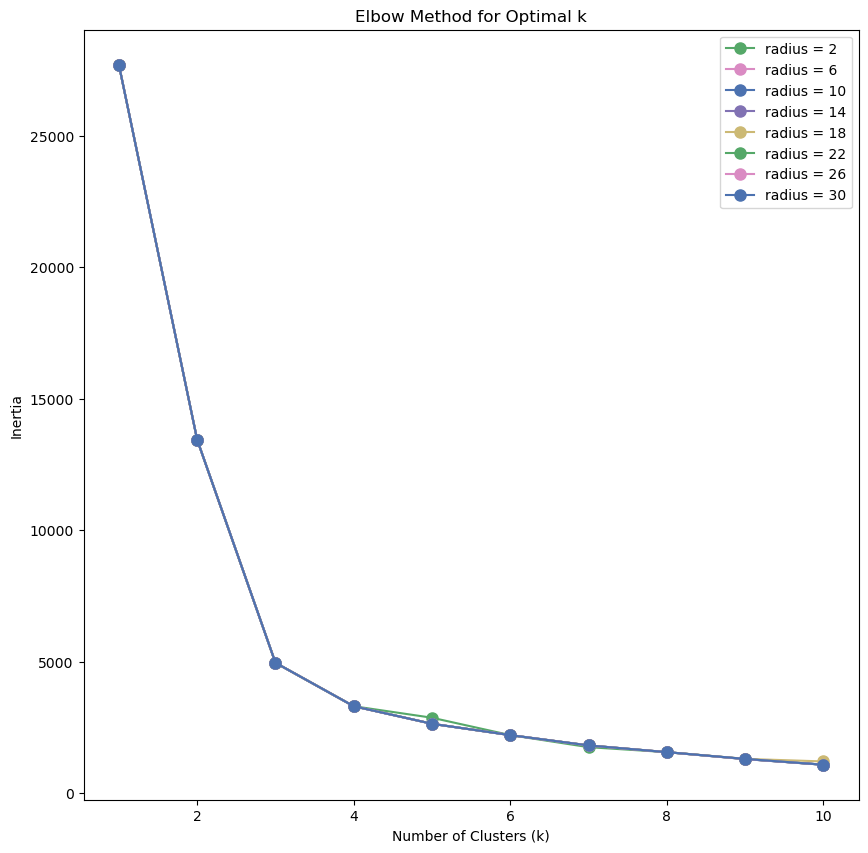

In [63]:
# Load your cleaned dataset
# Assuming the DataFrame 'hiv_data' with a column 'Ligand SMILES' is already prepared
smiles_list = hiv_data['Ligand SMILES'].tolist()

radiuses = [2,6,10,14,18,22,26,30]
ncols, nrows = 4, 2
pca_results = []
variance_explained = []
fgs= []
plt.figure(figsize=(10, 10))
pallete = sns.palettes.color_palette('deep',n_colors=35)
# Generate fingerprints
for radius in radiuses:
    print(f'doing radius {radius}')
    fingerprint_matrix = generate_fingerprints(smiles_list)
    scaler = StandardScaler()
    fingerprint_matrix_scaled = scaler.fit_transform(fingerprint_matrix)
    fgs.append(fingerprint_matrix)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(fingerprint_matrix)
    pca_results.append(pca_result)
    variance_explained.append(pca.explained_variance_ratio_)
    inertia = []
    K = range(1, 11)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pca_result)
        inertia.append(kmeans.inertia_)

    # Plot the Elbow curve
    plt.plot(K, inertia, 'bo-', markersize=8, label=f'radius = {radius}',color=pallete[radius])

plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.legend()
plt.show()

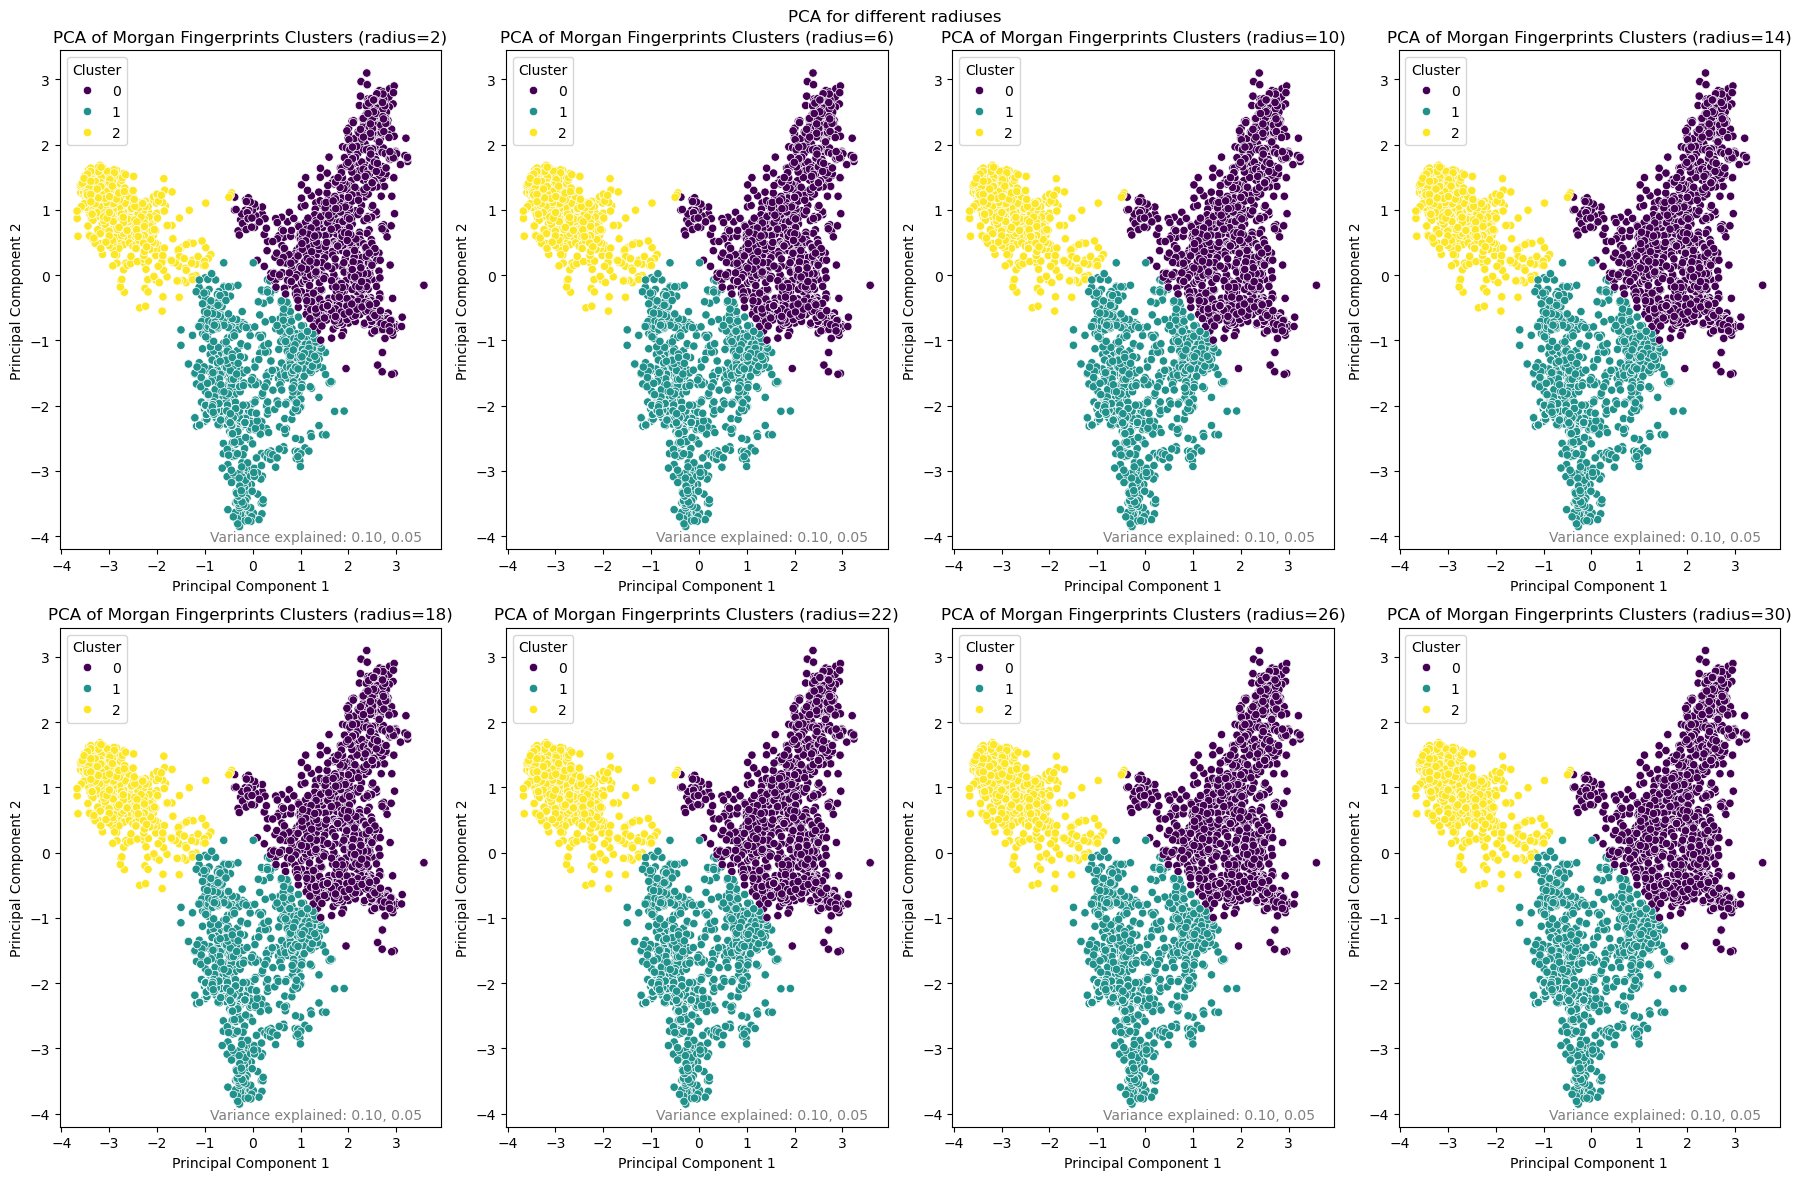

In [64]:
fig, axes = plt.subplots(ncols=ncols,nrows=nrows, figsize=(18, 12))
for idx, ax in enumerate(axes.flatten()):
    # Add PCA results to a DataFrame for easier plotting¨
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(pca_results[idx])
    pca_df = pd.DataFrame(pca_results[idx], columns=['PCA1', 'PCA2'])
    pca_df['Cluster'] = kmeans.labels_  # Assuming 'kmeans' is the model fitted with an optimal k

    # Visualize the PCA result
    
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis', ax=ax)
    ax.set_title(f'PCA of Morgan Fingerprints Clusters (radius={radiuses[idx]})')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')

    ax.text(0.95, 0.01, f'Variance explained: {variance_explained[idx][0]:.2f}, {variance_explained[idx][1]:.2f}',
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes, color='gray', fontsize=10)

plt.suptitle('PCA for different radiuses')
plt.tight_layout()
plt.show()

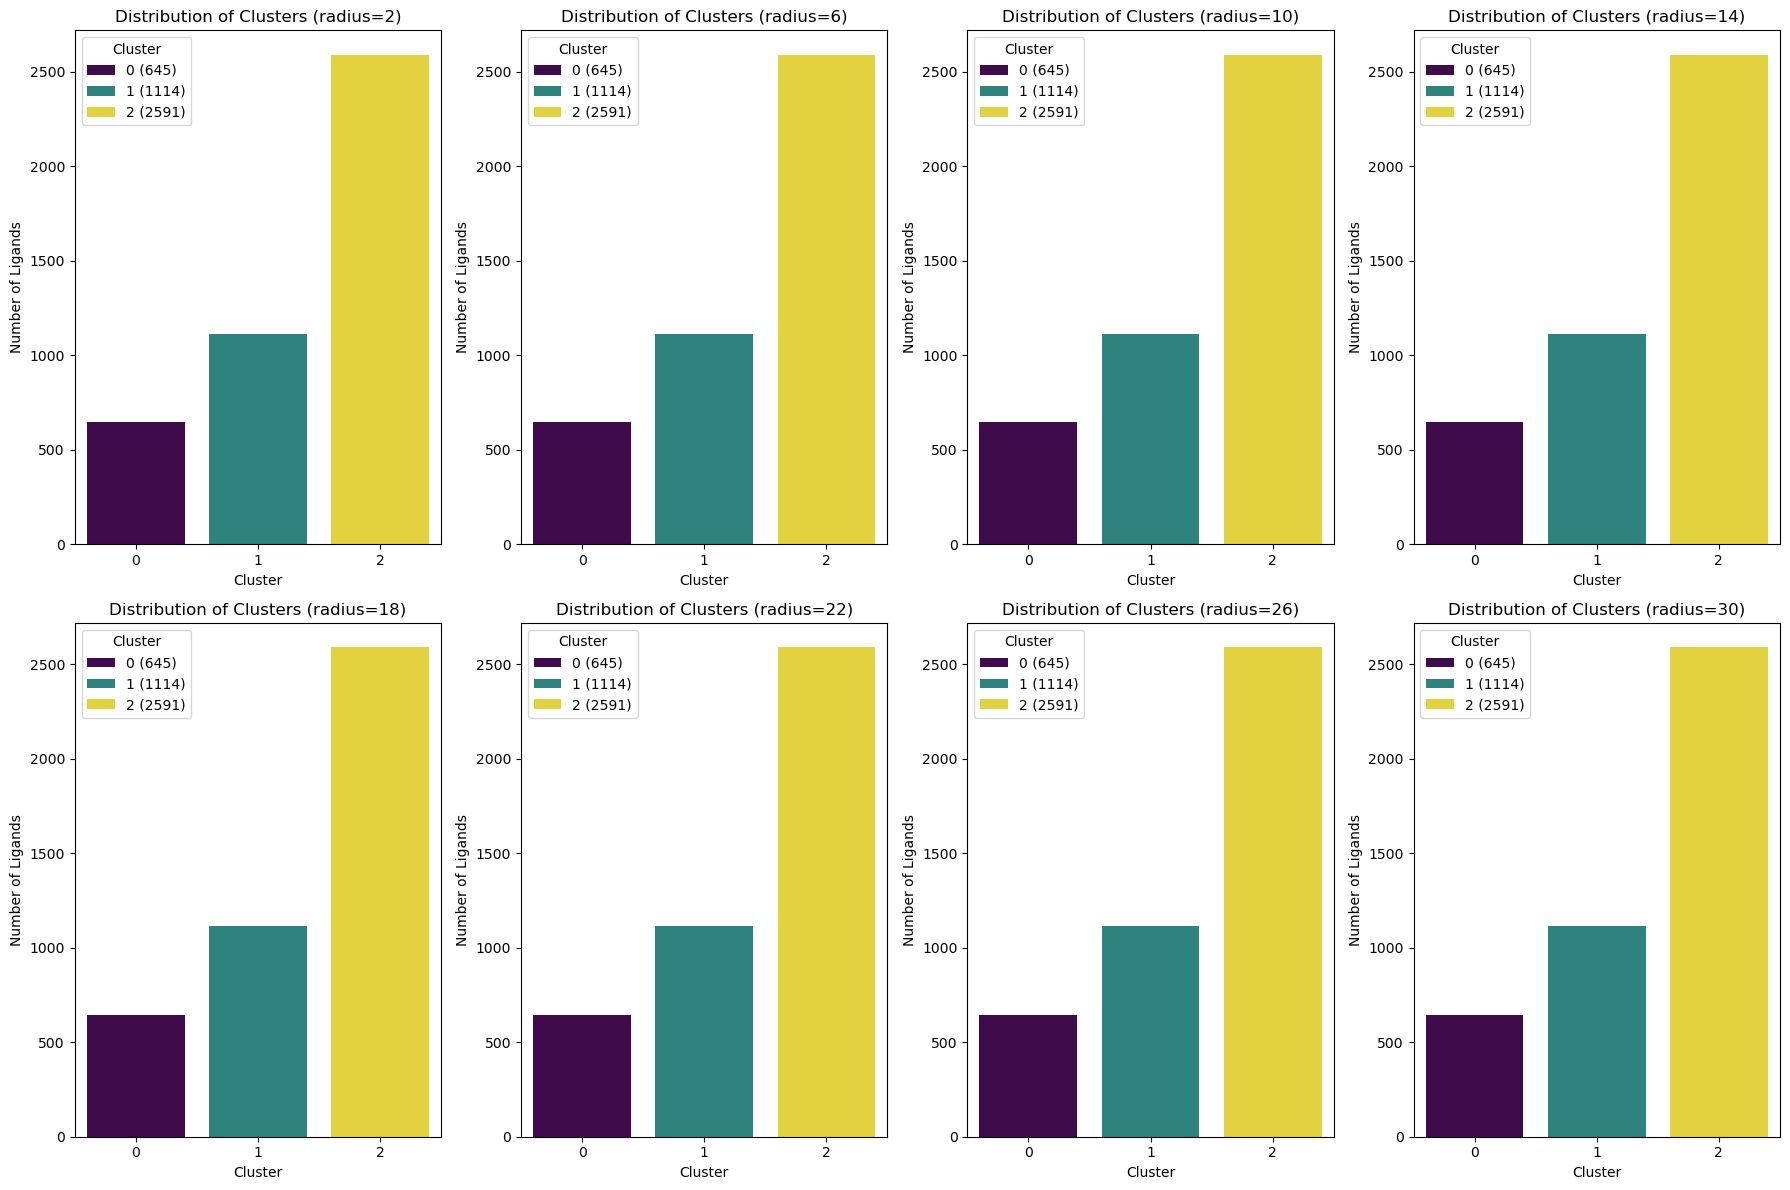

In [65]:
# Step 2: Perform Clustering with KMeans
# Adjust the number of clusters (n_clusters) as needed for your analysis
fig, axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=(18, 12))

for idx, ax in enumerate(axes.flatten()):
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(fgs[idx])

    # Add cluster labels to the DataFrame
    hiv_data[f'ClusterRadius{radiuses[idx]}'] = kmeans.labels_
    cluster_counts = hiv_data[f'ClusterRadius{radiuses[idx]}'].value_counts()

    sns.countplot(x=f'ClusterRadius{radiuses[idx]}', hue=f'ClusterRadius{radiuses[idx]}', data=hiv_data, palette='viridis', ax=ax)
    ax.set_title(f'Distribution of Clusters (radius={radiuses[idx]})')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Number of Ligands')

    handles, labels = ax.get_legend_handles_labels()
    labels = [f'{label} ({cluster_counts[int(label)]})' for label in labels]
    ax.legend(handles, labels, title='Cluster')

plt.tight_layout()
plt.show()

In [ ]:
cluster_dataframes={}
for cluster in range(6):
    cluster_dataframes[f'Cluster_{cluster}'] = hiv_data[hiv_data['Cluster'] == cluster]
    print(cluster_dataframes[f'Cluster_{cluster}'].groupby('Target Name').size().reset_index(name='Compound Count'))


                              Target Name  Compound Count
0  Dimer of Gag-Pol polyprotein [489-587]               2
1           Gag-Pol polyprotein [489-587]              88
             Target Name  Compound Count
0  Reverse transcriptase              68
                              Target Name  Compound Count
0  Dimer of Gag-Pol polyprotein [489-587]             134
1           Gag-Pol polyprotein [489-587]              72
                                         Target Name  Compound Count
0             Dimer of Gag-Pol polyprotein [489-587]             585
1       Dimer of Gag-Pol polyprotein [491-589,Q496K]              60
2  Dimer of Gag-Pol polyprotein [491-589,Q498K,L5...              17
3  Dimer of Gag-Pol polyprotein [501-599,Q508K,L5...              99
4             Dimer of Gag-Pol polyprotein [501-599]             377
5                        Envelope glycoprotein gp160              34
6                      Gag-Pol polyprotein [489-587]            1750
7                 

In [ ]:
#Extract molecular weight, h-bond, ... from clusters
from rdkit.Chem import Descriptors

def extract_info_smiles(data, molecular_weights, h_bond_donors, h_bond_acceptors, xlim=2000):
    for smiles in data['Ligand SMILES']:
        try:
            mol = Chem.MolFromSmiles(smiles)  # Create RDKit molecule object
            if mol:
                # Calculate properties if SMILES is valid
                molecular_weights.append(Descriptors.MolWt(mol))
                h_bond_donors.append(Descriptors.NumHDonors(mol))
                h_bond_acceptors.append(Descriptors.NumHAcceptors(mol))
            else:
                # Add None if SMILES is invalid
                molecular_weights.append(None)
                h_bond_donors.append(None)
                h_bond_acceptors.append(None)
        except Exception as e:
            # Handle invalid SMILES error by appending None
            print(f"Error processing SMILES {smiles}: {e}")
            molecular_weights.append(None)
            h_bond_donors.append(None)
            h_bond_acceptors.append(None)

    # Add properties to DataFrame
    data['Molecular Weight'] = molecular_weights
    data['H-Bond Donors'] = h_bond_donors
    data['H-Bond Acceptors'] = h_bond_acceptors

    # Drop rows with any missing values in these new columns
    data.dropna(subset=['Molecular Weight', 'H-Bond Donors', 'H-Bond Acceptors'], inplace=True)

    # Visualization (same as before)
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.histplot(data['Molecular Weight'], bins=30, color="skyblue")
    plt.title("Distribution of Molecular Weight in HIV-Targeting Compounds")
    plt.xlabel("Molecular Weight (g/mol)")
    plt.ylabel("Frequency")
    plt.xlim([0, xlim])
    plt.show()

C:\Users\nithu\AppData\Local\Temp\ipykernel_86168\414152641.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Molecular Weight'] = molecular_weights
C:\Users\nithu\AppData\Local\Temp\ipykernel_86168\414152641.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['H-Bond Donors'] = h_bond_donors
C:\Users\nithu\AppData\Local\Temp\ipykernel_86168\414152641.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

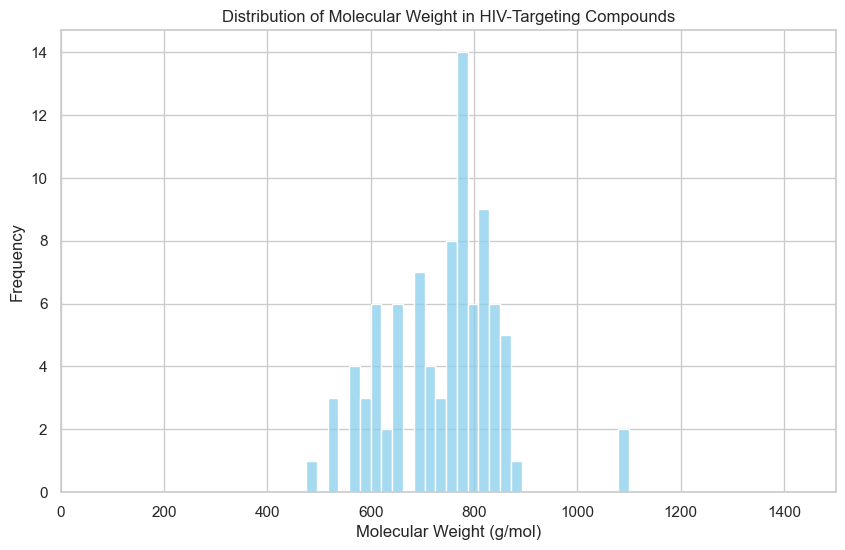

In [ ]:
molecular_weights_0 = []
h_bond_donors_0 = []
h_bond_acceptors_0 = []

extract_info_smiles(cluster_dataframes['Cluster_0'], molecular_weights_0, h_bond_donors_0, h_bond_acceptors_0, xlim=1500)

C:\Users\nithu\AppData\Local\Temp\ipykernel_86168\414152641.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Molecular Weight'] = molecular_weights
C:\Users\nithu\AppData\Local\Temp\ipykernel_86168\414152641.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['H-Bond Donors'] = h_bond_donors
C:\Users\nithu\AppData\Local\Temp\ipykernel_86168\414152641.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

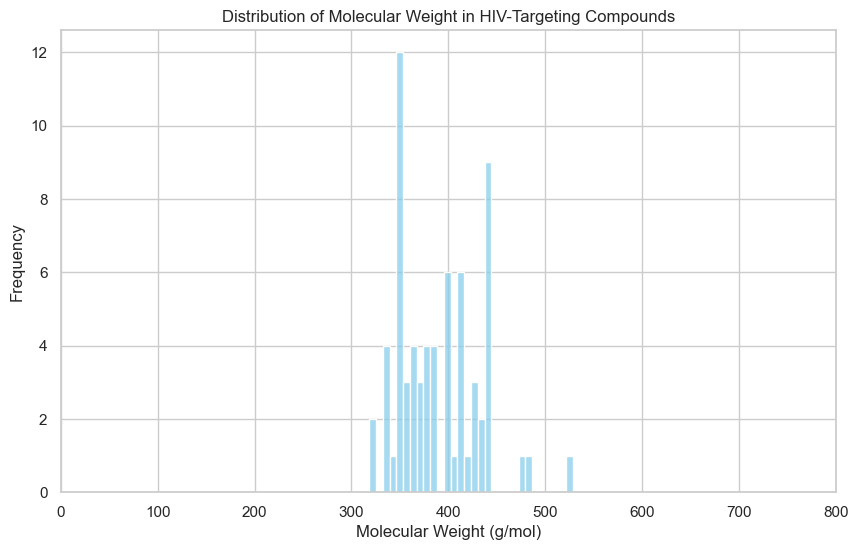

In [ ]:
molecular_weights_1 = []
h_bond_donors_1 = []
h_bond_acceptors_1 = []

extract_info_smiles(cluster_dataframes['Cluster_1'], molecular_weights_1, h_bond_donors_1, h_bond_acceptors_1, xlim=800)